# MeLU vs. Leaky ReLU

In [344]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

class MeLU(torch.nn.Module): # mixture of expert linear unit

    def __init__(self, s=0.01, a=1, b=0):
        super(MeLU, self).__init__()
        '''
        s: slope of left part (learned: optional)
        '''
        self.s = torch.tensor(s).float()
        self.a = torch.tensor(a).float()
        self.b = torch.nn.Parameter(torch.tensor(b).float())                                                                                                                                                                                                                          

    def forward(self, x):
        r = x
        l = self.s * x
        m = torch.sigmoid(self.a * (x - self.b))
        return (1-m) * l + m * r
    
class MPLU(torch.nn.Module): # mixture of piecewise linear unit                                                                                                             
    '''                                                                                                                                                                                                                                                                         
     same as above; just use a linear piece to combine instead of                                                                                                                                                                                                                
    mixture of the output                                                                                                                                                                                                                                                       
    '''                                                                                                                                                                                                                                                                         
    def __init__(self, s=0.01, a=1, b=0):                                                                                                                                                                                                                                       
        super(MPLU, self).__init__()                                                                                                                                                                                                                                            
        '''                                                                                                                                                                                                                                                                     
        s: slope of left part (learned: optional)                                                                                                                                                                                                                               
        a: width of middle piece; large a -> large width                                                                                                                                                                                                                        
        b: bias of the switching point                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                                     
        self.s = torch.tensor(s).float()
        self.a = torch.tensor(a).float()
        self.b = torch.nn.Parameter(torch.tensor(b).float())                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                
    def forward(self, x):                                                                                                                                                                                                                                                       
        w = torch.nn.functional.softplus(self.a)                       
        o = x.clone()                                                                                                                                                                                                                                                           
        o[x <= (self.b - w)] = self.s * x[x <= (self.b - w)]                                                                                                                                                                                                                    
        m = (x > (self.b - w)) * (x < self.b)  
        o[m] = self.s * (self.b - w) + (self.b - self.s * (self.b - w)) / w * (x[m] - self.b + w)                                                                                                                                                                                       
        return o                                          
    
class SReLU(torch.nn.Module):                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                
    '''                                                                                                                                                                                                                                                                         
    This aaai2016 paper has an interesting discussion about initialization and                                                                                                                                                                                                  
    freezing schme to learn the individual parameters                                                                                                                                                                                                                           
    '''                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                
    def __init__(self, l=0, r=1, al=0.01, ar=1): # init to leaky relu                                                                                                                                                                                                           
        super(SReLU, self).__init__()
        self.l = torch.nn.Parameter(torch.tensor(l).float())                                                                                                                                                                                                                          
        self.r = torch.nn.Parameter(torch.tensor(r).float())                                                                                                                                                                                                                           
        self.al = torch.nn.Parameter(torch.tensor(al).float())                                                                                                                                                                                                                        
        self.ar = torch.nn.Parameter(torch.tensor(ar).float())                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                
    def forward(self, x):                                                                                                                                                                                                                                                       
        o = x.clone()                                                                                                                                                                                                                                                           
        o[x >= self.r]  = self.r + self.ar * (x[x >= self.r] - self.r)                                                                                                                                                                                                          
        o[x <= self.l]  = self.l + self.al * (x[x <= self.l] - self.l)                                                                                                                                                                                                          
        return o   


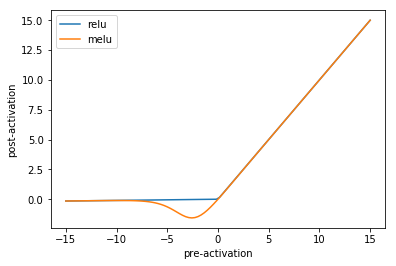

In [442]:
x = torch.linspace(-15, 15, 100)

relu = torch.nn.LeakyReLU()
y1 = relu(x)
melu = MeLU(a=1, b=-3)
y2 = melu(x)
mplu = MPLU(a=1, b=-3)
y3 = mplu(x)
srelu = SReLU(l=-5, r=5, al=0.01, ar=0.5) # the other baseline
y4 = srelu(x)

plt.plot(x.numpy(), y1.detach().numpy(), label='relu')
plt.plot(x.numpy(), y2.detach().numpy(), label='melu')
# plt.plot(x.numpy(), y3.detach().numpy(), label='mplu')
# plt.plot(x.numpy(), y4.detach().numpy(), label='srelu')

plt.legend()
plt.xlabel('pre-activation')
plt.ylabel('post-activation')
plt.show()

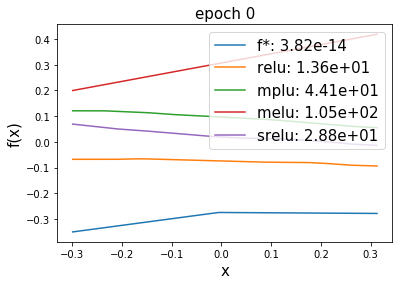

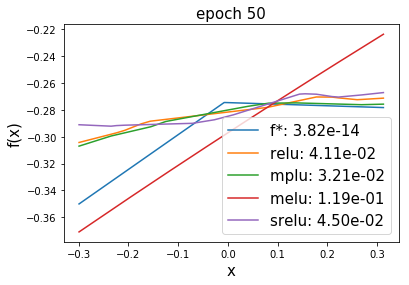

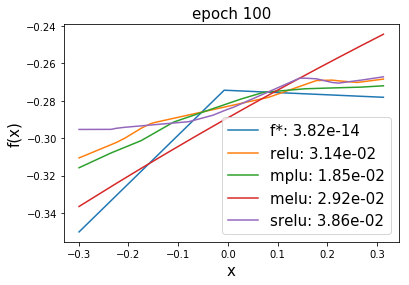

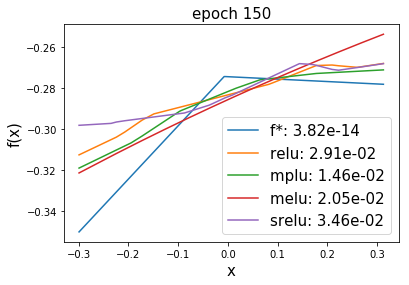

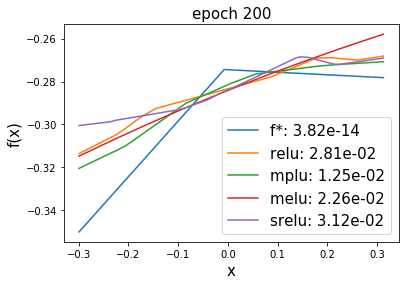

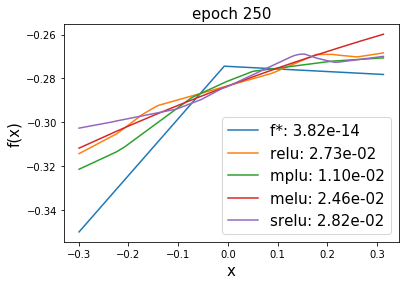

In [439]:
class SimpleNet(torch.nn.Module):
    '''
    linear x activation x linear network
    inspired by https://www.youtube.com/watch?v=-zQL9KYnQTc&list=WL&index=74
    '''
    def __init__(self, d, activation, n_in=1, n_out=1):
        super(SimpleNet, self).__init__()
        self.d = d # hidden size
        self.first_layer = torch.nn.Linear(n_in, d, bias=True)
        self.activation = activation
        self.last_layer = torch.nn.Linear(d, n_out, bias=True)
        
    def forward(self, x):
        return self.last_layer(self.activation(self.first_layer(x)))
    
def plot_nets_output(nets, x, Net2label, Net2loss, title="", loss_fmt='{:.2f}'):
    for net in nets:
        plt.plot(x.numpy(), net(x).detach().numpy(), '-', 
                 label=('{}: ' + loss_fmt).format(Net2label[net], Net2loss[net]))
    plt.xlabel('x', fontsize=15)
    plt.ylabel('f(x)', fontsize=15)
    plt.legend(fontsize=15)
    plt.title(title, fontsize=15)
    plt.show()

def train_simple_net(net, loader, lr=0.01, use_adam=False, amsgrad=False):
    if use_adam:
        opt = torch.optim.Adam(net.parameters(), lr=lr, amsgrad=amsgrad)
    else:
        opt = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    for x, y in loader:
        o = net(x)
        l = criterion(o, y)
        net.zero_grad()
        l.backward()
        opt.step()
        
def test_simple_net(net, loader):
    loss = 0
    criterion = torch.nn.MSELoss()
    for x, y in loader:
        o = net(x)
        l = criterion(o, y)
        loss += l.detach().item() * o.shape[0]
    return loss

def gen_x_y(f_star, scale=1, x=None):
    if x is None:
        x = torch.randn(n) * scale
    x = x.sort()
    x = x[0].view(-1, 1)
    y = f_star(x).detach()
    return x, y

d_star = 10
d = 50
n_in = 1
n_out = 1
bs = 10
n = 300
n_epochs = 300 
scale = 0.1
f_star = SimpleNet(d_star, torch.nn.ReLU(), n_in=n_in, n_out=n_out)
relu_net = SimpleNet(d, torch.nn.LeakyReLU(), n_in=n_in, n_out=n_out)
mplu_net = SimpleNet(d, MPLU(), n_in=n_in, n_out=n_out)
melu_net = SimpleNet(d, MeLU(), n_in=n_in, n_out=n_out)
srelu_net = SimpleNet(d, SReLU(), n_in=n_in, n_out=n_out)

Net2label = {
    f_star: 'f*',
    relu_net: 'relu', 
    mplu_net: 'mplu', 
    melu_net: 'melu',
    srelu_net: 'srelu'
}
nets = [f_star, relu_net, mplu_net, melu_net, srelu_net]
Net2loss = dict([(net, 0) for net in nets])
Net2losses = dict([(net, []) for net in nets])

x, y = gen_x_y(f_star, scale)
loader = data.DataLoader(data.TensorDataset(x, y), batch_size=bs)
test_loader = data.DataLoader(data.TensorDataset(*gen_x_y(scale)), batch_size=bs)

for i in range(n_epochs):
    if i % 50 == 0:
        for net in nets:
            loss = test_simple_net(net, test_loader)
            Net2loss[net] = loss
            Net2losses[net].append(loss)
        plot_nets_output(nets, x, Net2label, Net2loss, loss_fmt='{:.2e}',
                         title='epoch {}'.format(i))
        
    for net in nets:
        if net == f_star: continue
        train_simple_net(net, loader)

# for net in nets:
#     plt.plot(Net2losses[net], label=Net2label[net])
# plt.legend(fontsize=15)
# plt.show()

toy case 1


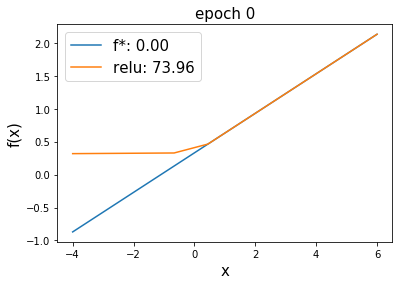

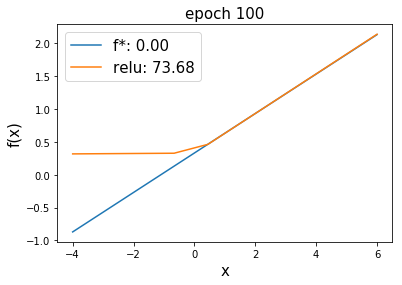

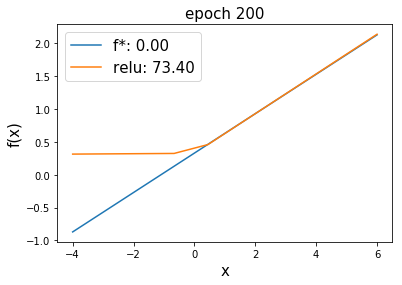

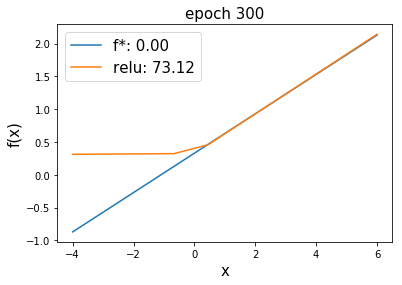

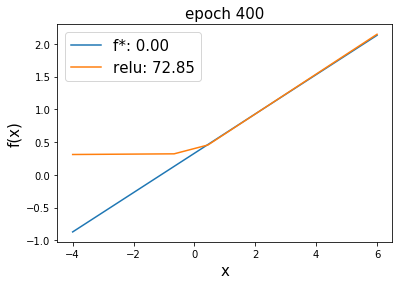

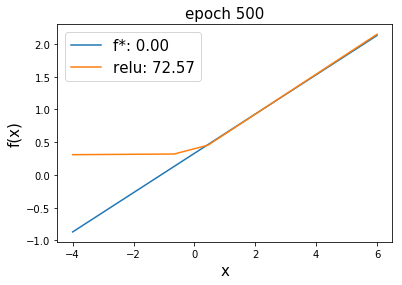

[Parameter containing:
tensor([[1.]]), Parameter containing:
tensor([-0.0106], requires_grad=True), Parameter containing:
tensor([[0.3058]], requires_grad=True), Parameter containing:
tensor([0.3197], requires_grad=True)]


In [682]:
print('toy case 1')

def set_simple_net(net, f_star, freeze=True):
    net.d = 1
    net.first_layer.weight.data.fill_(1) # make it identity
    net.first_layer.bias.data.fill_(0)
    net.last_layer.weight.data.fill_(f_star.weight.data[0].item())
    net.last_layer.bias.data.fill_(f_star.bias.data.item())
    if freeze:
        net.first_layer.weight.requires_grad = False
#         net.first_layer.bias.requires_grad = False
#         net.last_layer.weight.requires_grad = False
#         net.last_layer.bias.requires_grad = False
    return net

d_star = 1
d = 1
n_in = 1
n_out = 1
bs = 10
n = 10 # 300
n_epochs = 600
scale = 10
generate_new_f_star = False

if generate_new_f_star:
    f_star = torch.nn.Linear(n_in, n_out)
    f_star.weight.data.fill_(0.3)

relu_net = set_simple_net(SimpleNet(d, torch.nn.LeakyReLU(), n_in=n_in, n_out=n_out), f_star)
mplu_net = set_simple_net(SimpleNet(d, MPLU(), n_in=n_in, n_out=n_out), f_star)
melu_net = set_simple_net(SimpleNet(d, MeLU(), n_in=n_in, n_out=n_out), f_star)
srelu_net = set_simple_net(SimpleNet(d, SReLU(), n_in=n_in, n_out=n_out), f_star)

'''
Adam: (1, -0.4534, 0.7083, -0.3359) log loss: 2
SGD:  (1, 3.3574, 0.3067, -0.7435)  log loss: 0
'''
adam_solution = (1, -0.4534, 0.7083, -0.3359)
# for i, p in enumerate(relu_net.parameters()):
#     p.data.fill_(adam_solution[i])

Net2label = {
    f_star: 'f*',
    relu_net: 'relu', 
#     mplu_net: 'mplu', 
#     melu_net: 'melu',
#     srelu_net: 'srelu'
}
nets = Net2label.keys()
Net2loss = dict([(net, 0) for net in nets])

def gen_x(n, repeat=1):
    #x = torch.rand(n)*10 - 4
    x = torch.linspace(-4, 6, n)
    return torch.cat([x]*repeat)

x, y = gen_x_y(f_star, x=gen_x(n, repeat=30))
loader = data.DataLoader(data.TensorDataset(x, y), batch_size=bs)
test_loader = data.DataLoader(data.TensorDataset(*gen_x_y(f_star, x=gen_x(n, repeat=30))), batch_size=bs)

for i in range(n_epochs):
    if i % 100 == 0:
        for net in nets:
            loss = test_simple_net(net, test_loader)
            Net2loss[net] = loss
        plot_nets_output(nets, x, Net2label, Net2loss, loss_fmt='{:.2f}', 
                         title='epoch {}'.format(i))
        
    for net in nets:
        if net == f_star: continue
        train_simple_net(net, loader, lr=1e-6, use_adam=True, amsgrad=True) # lr=1e-4 for adam with amsgrad; lr=1e-2
        #train_simple_net(net, loader, lr=1e-2, use_adam=False, amsgrad=True)

print(list(relu_net.parameters()))

Adam:
[Parameter containing:
tensor([[1.]]), Parameter containing:
tensor([-0.4534], requires_grad=True), Parameter containing:
tensor([[0.7083]], requires_grad=True), Parameter containing:
tensor([-0.3359], requires_grad=True)]
loss: 122.25
    
SGD:
[Parameter containing:
tensor([[1.]]), Parameter containing:
tensor([3.3574], requires_grad=True), Parameter containing:
tensor([[0.3067]], requires_grad=True), Parameter containing:
tensor([-0.7435], requires_grad=True)]
loss: 1.67

'''
Adam: (-0.4534, 0.7083, -0.3359) log loss: 2
SGD:  (3.3574, 0.3067, -0.7435)  log loss: 0
'''

In [672]:
from itertools import product

def sanitize_range(r, fmt='{:.2f}'): # for better printing
    return list(map(lambda x: float(fmt.format(x)), r))

criterion = torch.nn.MSELoss()
x, y = gen_x_y(f_star, x=gen_x(10, repeat=30))
relu_net = set_simple_net(SimpleNet(d, torch.nn.LeakyReLU(), n_in=n_in, n_out=n_out), f_star)
print(list(relu_net.parameters()))

# 3 parameters to vary
b1_search_range = np.linspace(-1, 4, 12)
b2_search_range = sanitize_range(np.linspace(-1, 1, 9))
w2_search_range = sanitize_range(np.linspace(-1, 1, 9))

losses = []
for param in product(b1_search_range, w2_search_range, b2_search_range):
    for i, p in enumerate(relu_net.parameters()):
        if i==0: continue # skip the first layer weight
        p.data.fill_(param[i-1])
        
    loss = criterion(relu_net(x), y).detach().item()
    losses.append(list(param) + [loss * 300])
    
df = pd.DataFrame(losses, columns=['b', 'c', 'd', 'loss'])

[Parameter containing:
tensor([[1.]]), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[0.3000]], requires_grad=True), Parameter containing:
tensor([0.3297], requires_grad=True)]


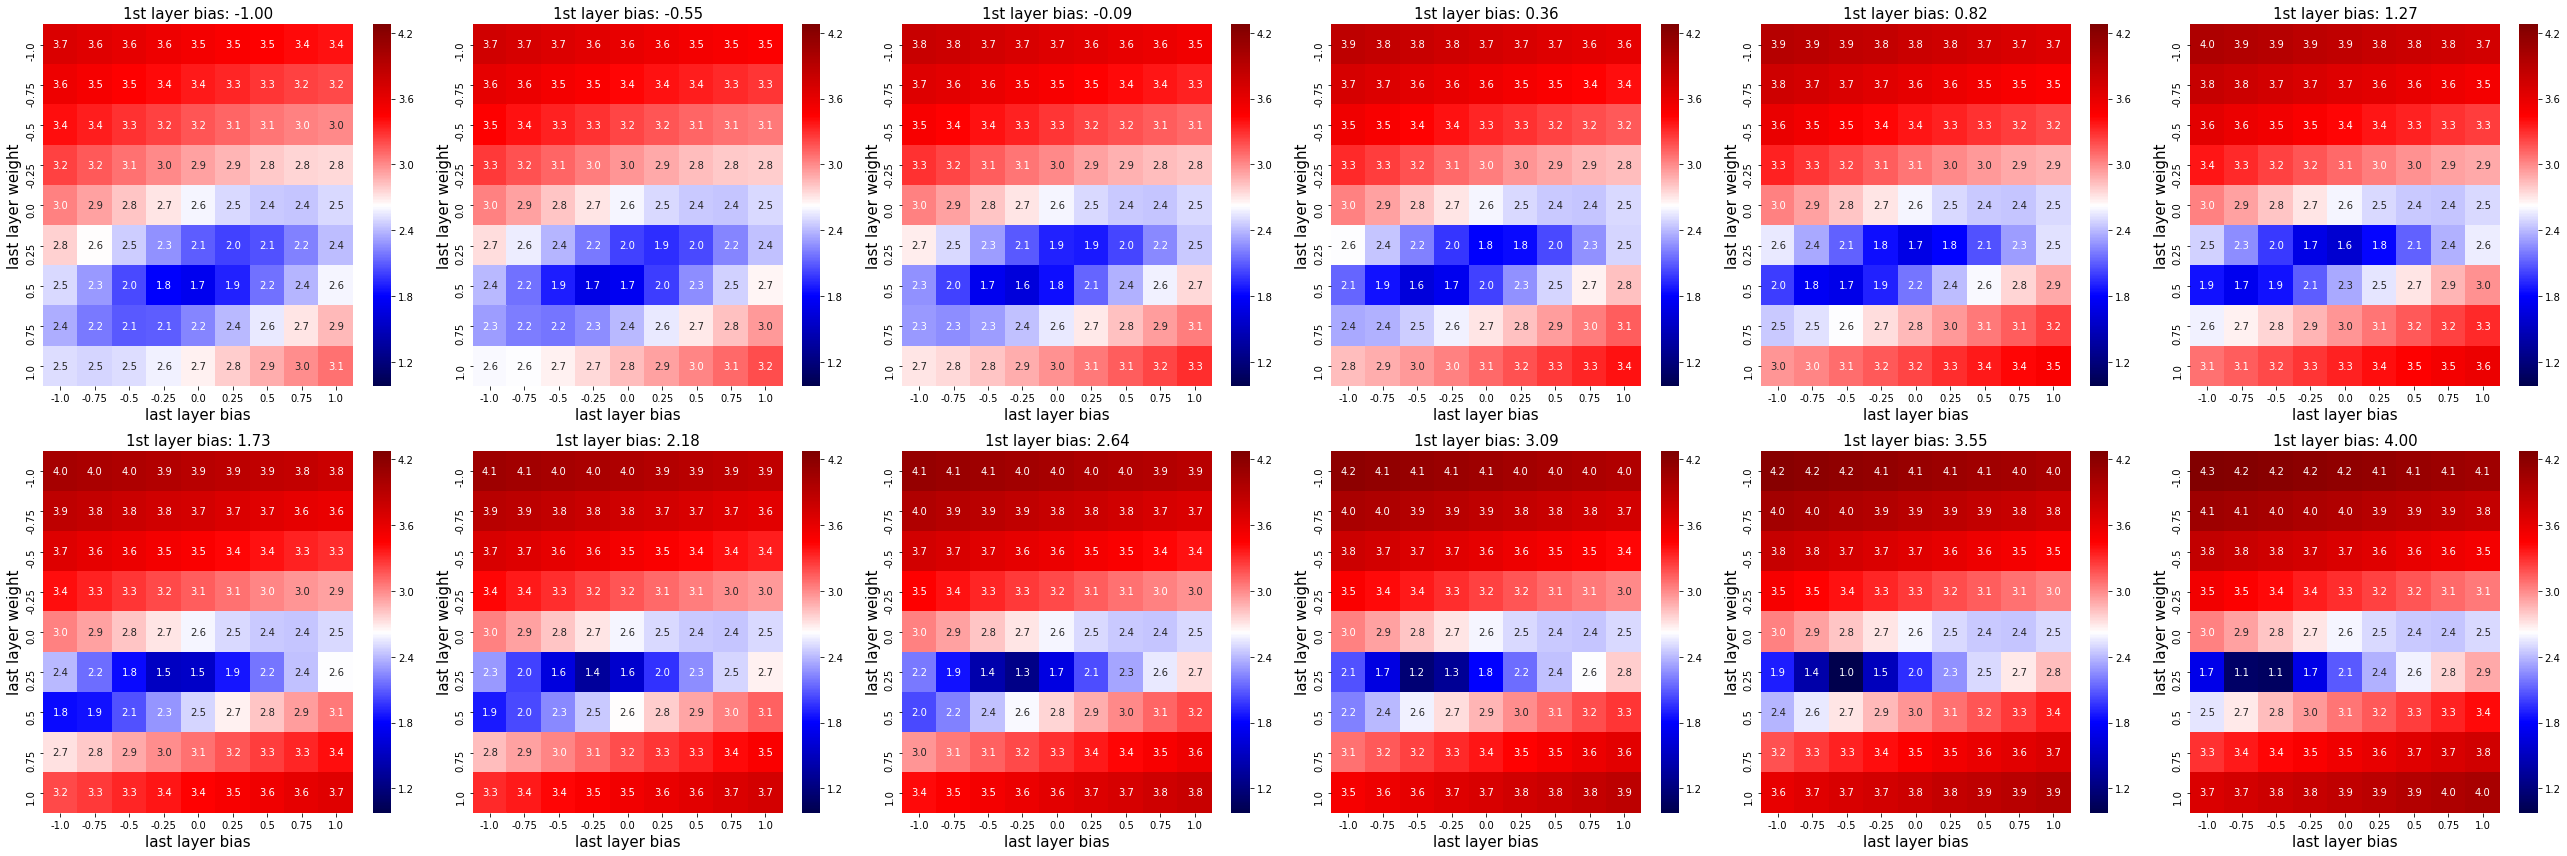

'\nAdam: (-0.4534, 0.7083, -0.3359) log loss: 2\nSGD:  (3.3574, 0.3067, -0.7435)  log loss: 0\n'

In [668]:
def plot_c_d(df, b, vmin=-1.5 + 2.477, vmax=1.8 + 2.477):
    df = df[df['b'] == b]
    df = df.groupby(['c', 'd'], as_index=False).mean()
    sns.heatmap(np.log10(df.pivot(index='c', columns='d', values='loss')), 
                cmap='seismic', annot=True, fmt=".1f", vmin=vmin, vmax=vmax,
                xticklabels=True, yticklabels=True)

    plt.ylabel('last layer weight', fontsize=15)
    plt.xlabel('last layer bias', fontsize=15)
    plt.title('1st layer bias: {:.2f}'.format(b), fontsize=15)
    
fig = plt.figure(figsize=(36, 12))
for i, b in enumerate(b1_search_range):
    fig.add_subplot(2, 6, i+1)
    plot_c_d(df, b)
    
plt.tight_layout()
plt.show()

'''
Adam: (-0.4534, 0.7083, -0.3359) log loss: 2
SGD:  (3.3574, 0.3067, -0.7435)  log loss: 0
'''

[Parameter containing:
tensor([[1.]]), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[0.3000]], requires_grad=True), Parameter containing:
tensor([0.3297], requires_grad=True)]


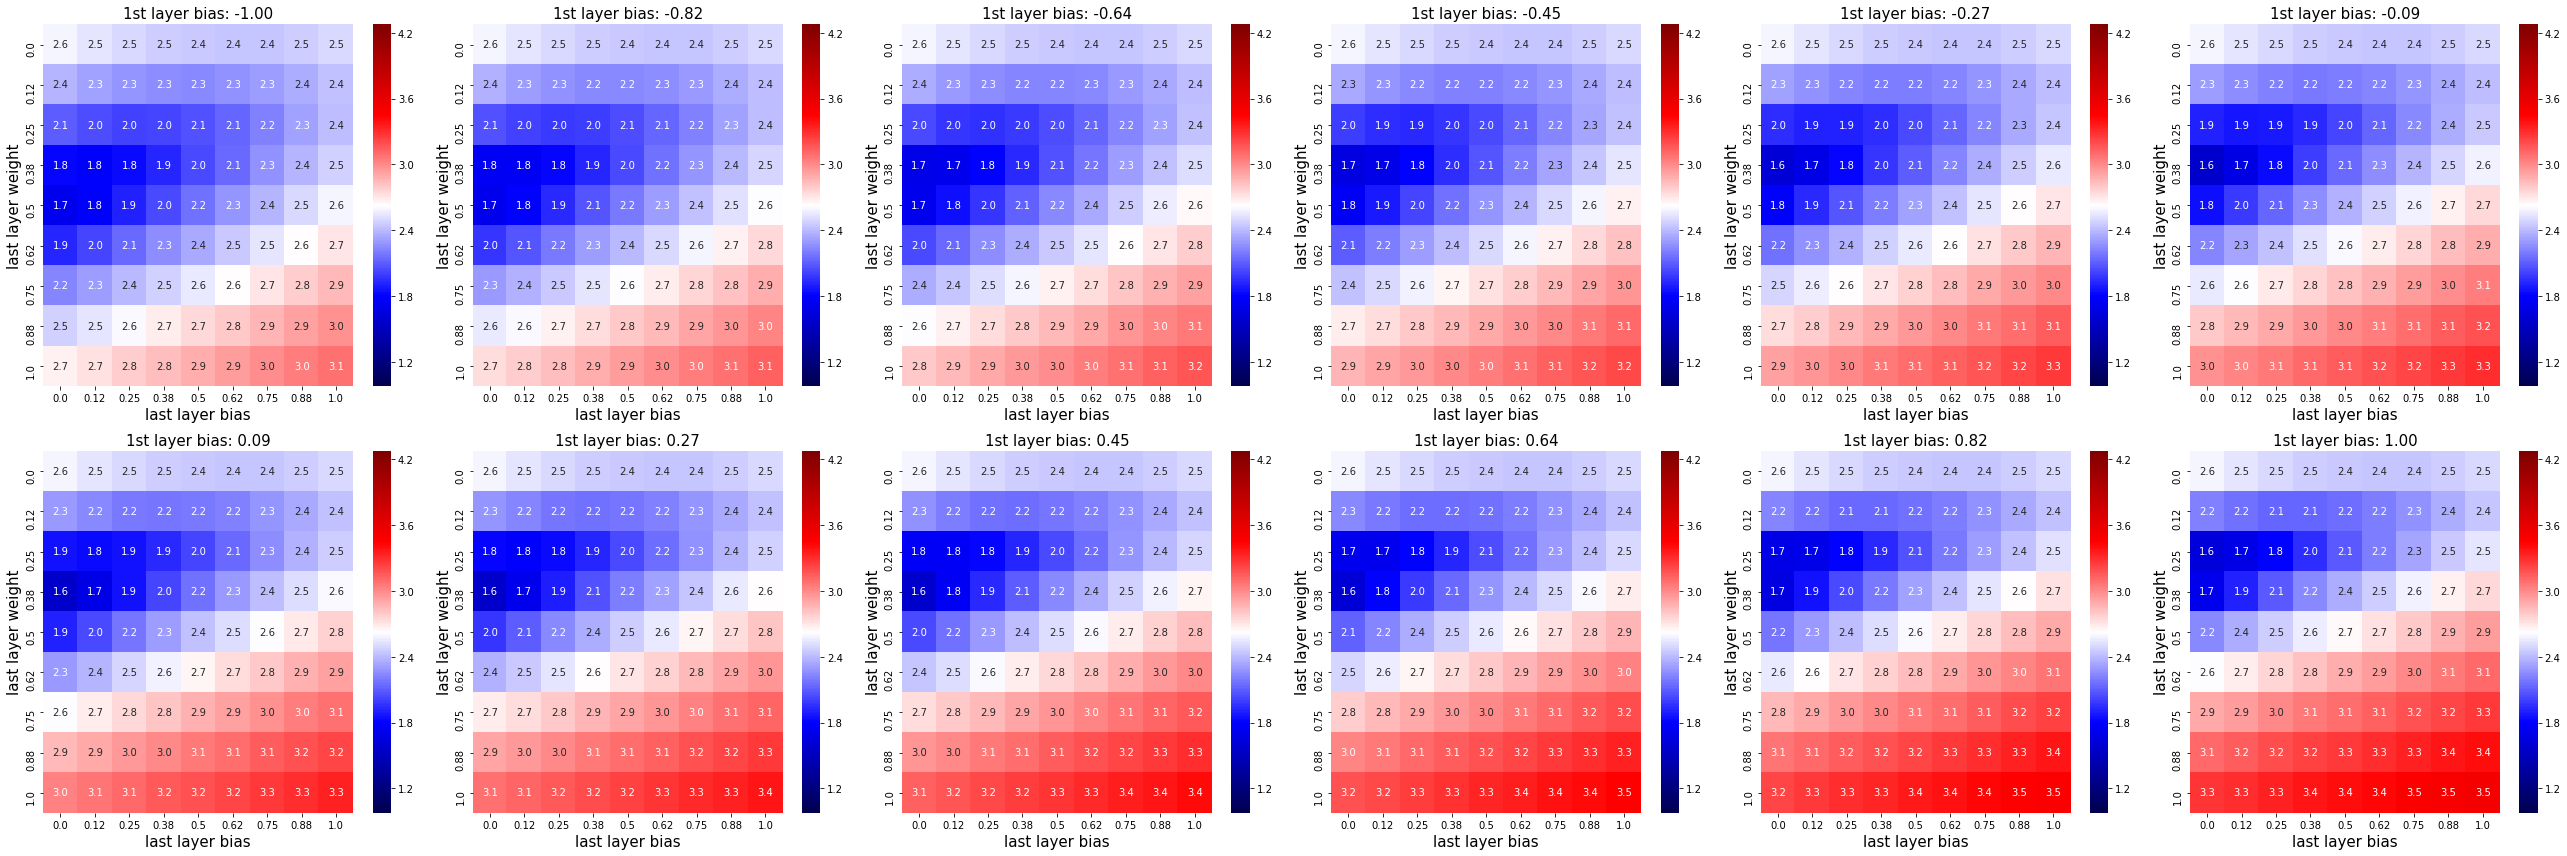

In [683]:
criterion = torch.nn.MSELoss()
x, y = gen_x_y(f_star, x=gen_x(10, repeat=30))
relu_net = set_simple_net(SimpleNet(d, torch.nn.LeakyReLU(), n_in=n_in, n_out=n_out), f_star)

# (1, 0, 0.3, 0.3297) for init parameter
# 3 parameters to vary
b1_search_range = np.linspace(-1, 1, 12)
b2_search_range = sanitize_range(np.linspace(0, 1, 9))
w2_search_range = sanitize_range(np.linspace(0, 1, 9))

losses = []
for param in product(b1_search_range, w2_search_range, b2_search_range):
    for i, p in enumerate(relu_net.parameters()):
        if i==0: continue # skip the first layer weight
        p.data.fill_(param[i-1])
        
    loss = criterion(relu_net(x), y).detach().item()
    losses.append(list(param) + [loss * 300])
    
df = pd.DataFrame(losses, columns=['b', 'c', 'd', 'loss'])

fig = plt.figure(figsize=(36, 12))
for i, b in enumerate(b1_search_range):
    fig.add_subplot(2, 6, i+1)
    plot_c_d(df, b)
    
plt.tight_layout()
plt.show()


toy case 2


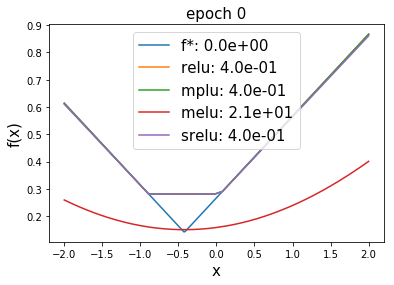

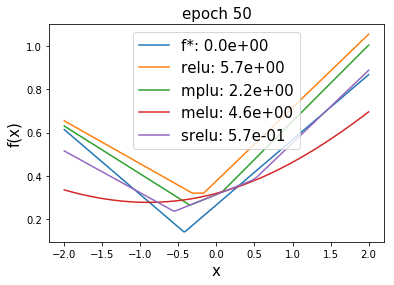

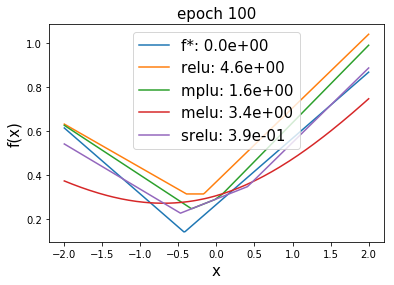

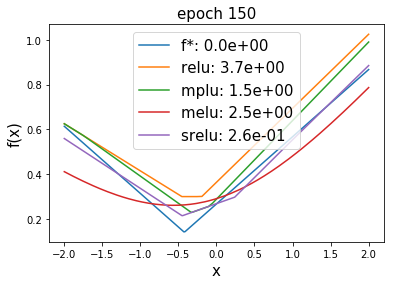

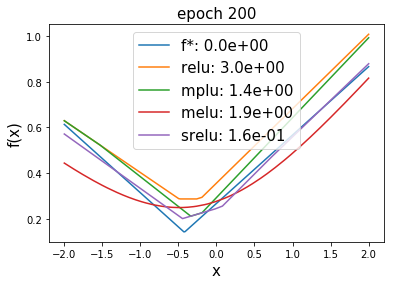

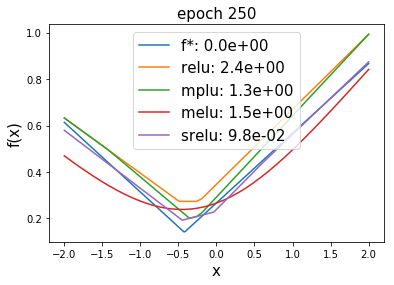

In [435]:
print('toy case 2')

def set_simple_net(net, f_star, freeze=False):
    net.last_layer.weight.data = f_star.last_layer.weight.data
    net.last_layer.bias.data = f_star.last_layer.bias.data
    net.first_layer.weight.data = f_star.first_layer.weight.data
    net.first_layer.bias.data = f_star.first_layer.bias.data
#     net.last_layer.weight.data.fill_(f_star.weight.data[0].item())
#     net.last_layer.bias.data.fill_(f_star.bias.data.item())
#     if freeze:
#         net.first_layer.weight.requires_grad = False
#         net.first_layer.bias.requires_grad = False
#         net.last_layer.weight.requires_grad = False
#         net.last_layer.bias.requires_grad = False
    return net
    
d_star = 2
d = 2
n_in = 1
n_out = 1
bs = 10
n = 300
n_epochs = 300
scale = 10

f_star = SimpleNet(d_star, torch.nn.ReLU(), n_in=n_in, n_out=n_out)
f_star.first_layer.weight.data = torch.Tensor([[0.3], [-0.3]]) 
f_star.last_layer.weight.data.fill_(1) # make it identity
f_star.last_layer.bias.data.fill_(0) # make it identity
bias = f_star.first_layer.bias.data.view(-1)

relu_net = set_simple_net(SimpleNet(d, torch.nn.LeakyReLU(negative_slope=0), n_in=n_in, n_out=n_out), f_star)
mplu_net = set_simple_net(SimpleNet(d, MPLU(s=0), n_in=n_in, n_out=n_out), f_star, freeze=False)
melu_net = set_simple_net(SimpleNet(d, MeLU(s=0), n_in=n_in, n_out=n_out), f_star, freeze=False)
srelu_net = set_simple_net(SimpleNet(d, SReLU(), n_in=n_in, n_out=n_out), f_star, freeze=False)

# recreate f_star
class TargetNet(torch.nn.Module):
    
    def __init__(self):
        super(TargetNet, self).__init__()
        self.l = torch.nn.Linear(1,1)
        self.r = torch.nn.Linear(1,1)
        
    def forward(self, x):
        return torch.max(self.l(x), self.r(x))
    
f_star = TargetNet()
f_star.l.weight.data.fill_(-0.3)
f_star.l.bias.data.fill_(bias[1])
f_star.r.weight.data.fill_(0.3)
f_star.r.bias.data.fill_(bias[0])       
        
Net2label = {
    f_star: 'f*',
    relu_net: 'relu', 
    mplu_net: 'mplu', 
    melu_net: 'melu',
    srelu_net: 'srelu'
}
nets = Net2label.keys()
Net2loss = dict([(net, 0) for net in nets])

x, y = gen_x_y(x=torch.rand(n)*4-2)
loader = data.DataLoader(data.TensorDataset(x, y), batch_size=bs)
test_loader = data.DataLoader(data.TensorDataset(*gen_x_y(x=torch.rand(n)*4-2)), batch_size=bs)

for i in range(n_epochs):
    if i % 50 == 0:
        for net in nets:
            loss = test_simple_net(net, test_loader)
            Net2loss[net] = loss
        plot_nets_output(nets, x, Net2label, Net2loss, loss_fmt='{:.1e}', 
                         title='epoch {}'.format(i))
        
    for net in nets:
        if net == f_star: continue
        train_simple_net(net, loader, lr=1e-2, use_adam=False, amsgrad=False)
